##Including Libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

Reading the CSV files into Dataframes

In [2]:
df=pd.read_csv('USD_PKR Historical Data.csv')
dfdollar=pd.read_csv('USD_PKR Historical Data.csv')
dfcrude=pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
dfxau=pd.read_csv('XAU_PKR Historical Data.csv')

Arranging in an increasing order

In [3]:
df.reindex(index=df.index[::-1])
dfdollar.reindex(index=dfdollar.index[::-1])
dfcrude.reindex(index=dfcrude.index[::-1])
dfxau.reindex(index=dfxau.index[::-1])

,Date,Price,Open,High,Low,Vol.,Change %
782,09/26/2019,"234,959","235,841","237,229","233,923",NaN,0.08%
781,09/27/2019,"233,784","235,991","236,445","232,396",NaN,-0.50%
780,09/30/2019,"229,655","232,925","234,954","228,600",NaN,-1.77%
779,10/01/2019,"230,948","230,788","233,258","227,560",NaN,0.56%
778,10/02/2019,"233,951","231,987","235,927","229,930",NaN,1.30%
...,...,...,...,...,...,...,...
4,09/20/2022,"396,984","401,753","402,623","395,234",118.95K,-1.08%
3,09/21/2022,"397,932","397,856","402,264","393,935",51.93K,0.24%
2,09/22/2022,"399,199","398,621","402,893","394,500",95.73K,0.32%
1,09/23/2022,"393,452","400,248","401,545","392,425",90.17K,-1.44%


Informations about each Dataframe

In [541]:
print(dfdollar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      818 non-null    object 
 1   Price     818 non-null    float64
 2   Open      818 non-null    float64
 3   High      818 non-null    float64
 4   Low       818 non-null    float64
 5   Vol.      777 non-null    object 
 6   Change %  818 non-null    object 
dtypes: float64(4), object(3)
memory usage: 44.9+ KB
None


In [542]:
print(dfcrude.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      792 non-null    object 
 1   Price     792 non-null    float64
 2   Open      792 non-null    float64
 3   High      792 non-null    float64
 4   Low       792 non-null    float64
 5   Vol.      754 non-null    object 
 6   Change %  792 non-null    object 
dtypes: float64(4), object(3)
memory usage: 43.4+ KB
None


In [543]:
print(dfxau.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      783 non-null    object
 1   Price     783 non-null    object
 2   Open      783 non-null    object
 3   High      783 non-null    object
 4   Low       783 non-null    object
 5   Vol.      764 non-null    object
 6   Change %  783 non-null    object
dtypes: object(7)
memory usage: 42.9+ KB
None


Dropping the unwanted columns from each Dataframes

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

dfdollar['Date'] = pd.to_datetime(dfdollar['Date'])
dfdollar.set_axis(dfdollar['Date'], inplace=True)
dfdollar.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

dfcrude['Date'] = pd.to_datetime(dfcrude['Date'])
dfcrude.set_axis(dfcrude['Date'], inplace=True)
dfcrude.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

dfxau['Date'] = pd.to_datetime(dfxau['Date'])
dfxau.set_axis(dfxau['Date'], inplace=True)
dfxau.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

##For Univariate using Dollar to PKR price as a feature

In [177]:
price_data = df['Price'].values
price_data = price_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(price_data))

price_train = price_data[:split]
price_test = price_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(price_train))
print(len(price_test))

654
164


In [178]:
df=df.iloc[::-1]

In [179]:
df

,Date,Price
Date,,
2019-09-26,2019-09-26,156.15
2019-09-27,2019-09-27,156.20
2019-09-28,2019-09-28,156.85
2019-09-30,2019-09-30,156.00
2019-10-01,2019-10-01,156.15
...,...,...
2022-09-20,2022-09-20,238.50
2022-09-21,2022-09-21,237.80
2022-09-22,2022-09-22,239.50


Using TimeSeriesGenerator as a tool for generating the data

In [180]:
look_back = 15

train_generator = TimeseriesGenerator(price_train, price_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(price_test, price_test, length=look_back, batch_size=1)

Model Training

In [181]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



32/32 [==============================] - 1s 6ms/step - loss: 47930.5742
Epoch 2/25
32/32 [==============================] - 0s 7ms/step - loss: 6974.1167
Epoch 3/25
32/32 [==============================] - 0s 7ms/step - loss: 205.6391
Epoch 4/25
32/32 [==============================] - 0s 7ms/step - loss: 15.9393
Epoch 5/25
32/32 [==============================] - 0s 7ms/step - loss: 9.1463
Epoch 6/25
32/32 [==============================] - 0s 7ms/step - loss: 8.4425
Epoch 7/25
32/32 [==============================] - 0s 6ms/step - loss: 8.4486
Epoch 8/25
32/32 [==============================] - 0s 7ms/step - loss: 8.3526
Epoch 9/25
32/32 [==============================] - 0s 7ms/step - loss: 8.6943
Epoch 10/25
32/32 [==============================] - 0s 7ms/step - loss: 8.7301
Epoch 11/25
32/32 [==============================] - 0s 7ms/step - loss: 8.5491
Epoch 12/25
32/32 [==============================] - 0s 7ms/step - loss: 8.2246
Epoch 13/25
32/32 [==============================]

Predicting model on Test data

In [185]:
prediction = model.predict(test_generator)

price_train = price_train.reshape((-1))
price_test = price_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = price_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = price_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Dollar to PKR",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Price"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

Forecasting the Data

In [183]:
price_data = price_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = price_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [186]:
fore = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Dollar to Pkr",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Price"}
)
fig = go.Figure(data=[fore], layout=layout)
fig.show()

##For Multi-Variate

Renaming the columns for easy comprehension

In [5]:
dfdollar.rename(columns = {'Date' : 'Date', 'Price' : 'Dollar Price'}, inplace = True)
dfcrude.rename(columns = {'Date' : 'Date', 'Price' : 'Crude Price'}, inplace = True)
dfxau.rename(columns = {'Date' : 'Date', 'Price' : 'XAU Price'}, inplace = True)



Deleting previous dataframe so that it can be used as a combine multivariate dataframe

In [6]:
del(df)
df=pd.DataFrame()

Getting the indexes of the dataframes which have same time stamps across every field

In [7]:
common_date = set(dfdollar.Date).intersection(dfcrude.Date)
dfdollar = dfdollar.loc[common_date].copy()
dfcrude = dfcrude.loc[common_date].copy()
dfxau = dfxau.loc[common_date].copy()

In [548]:
dfdollar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 775 entries, 2021-04-07 to 2021-01-11
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          775 non-null    datetime64[ns]
 1   Dollar Price  775 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.2 KB


In [549]:
dfcrude.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 775 entries, 2021-04-07 to 2021-01-11
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         775 non-null    datetime64[ns]
 1   Crude Price  775 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.2 KB


In [550]:
dfxau.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 775 entries, 2021-04-07 to 2021-01-11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       775 non-null    datetime64[ns]
 1   XAU Price  775 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 18.2+ KB


Dropping the Data columns because all the dates are same in each dataframe

In [8]:
dfcrude.drop(columns=['Date'], inplace=True)
dfxau.drop(columns=['Date'], inplace=True)

Concatenating each of the Dataframe

In [9]:
df = pd.concat([dfdollar, dfcrude], axis=1)

In [10]:
df = pd.concat([df, dfxau], axis=1)

In [11]:
df.set_axis(df['Date'], inplace=True)

In [503]:
#df.reset_index(drop=True, inplace=True)

In [12]:
df.drop(columns=['Date'],inplace=True)

In [13]:
df.head()

,Dollar Price,Crude Price,XAU Price
Date,,,
2022-03-01,177.25,103.41,"344,714"
2022-07-20,224.75,102.26,"381,241"
2020-12-29,160.00,48.00,"300,473"
2022-07-19,221.50,104.22,"378,920"
2021-03-16,156.42,64.80,"270,773"


Rearranging the Dataframe

In [14]:
df.sort_values(by='Date',ascending=True,inplace=True)
df.head()

,Dollar Price,Crude Price,XAU Price
Date,,,
2019-09-26,156.15,56.41,"234,959"
2019-09-27,156.20,55.91,"233,784"
2019-09-30,156.00,54.07,"229,655"
2019-10-01,156.15,53.62,"230,948"
2019-10-02,156.00,52.64,"233,951"


Splitting for Train-Test

In [15]:
split=int(0.80*775)

In [16]:
split

620

In [17]:
df_train=df.iloc[0:split,:]

In [18]:
df_train.head(5)

,Dollar Price,Crude Price,XAU Price
Date,,,
2019-09-26,156.15,56.41,"234,959"
2019-09-27,156.20,55.91,"233,784"
2019-09-30,156.00,54.07,"229,655"
2019-10-01,156.15,53.62,"230,948"
2019-10-02,156.00,52.64,"233,951"


In [19]:
df_test=df.iloc[split:,:]

Changing the String value of XAU to float64

In [20]:
df_train['XAU Price']=df_train['XAU Price'].str.replace(",","")
df_train['XAU Price']=df_train['XAU Price'].astype('float64')
df_train.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Dollar Price,Crude Price,XAU Price
Date,,,
2019-09-26,156.15,56.41,234959.0
2019-09-27,156.20,55.91,233784.0
2019-09-30,156.00,54.07,229655.0
2019-10-01,156.15,53.62,230948.0
2019-10-02,156.00,52.64,233951.0


In [21]:
df_train.head()

,Dollar Price,Crude Price,XAU Price
Date,,,
2019-09-26,156.15,56.41,234959.0
2019-09-27,156.20,55.91,233784.0
2019-09-30,156.00,54.07,229655.0
2019-10-01,156.15,53.62,230948.0
2019-10-02,156.00,52.64,233951.0


In [22]:
df_test
df_test['XAU Price']=df_test['XAU Price'].str.replace(",","")
df_test['XAU Price']=df_test['XAU Price'].astype('float64')
df_test.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Dollar Price,Crude Price,XAU Price
Date,,,
2022-02-17,175.2,91.76,332522.0
2022-02-18,175.6,91.07,333266.0
2022-02-21,175.6,92.65,334698.0
2022-02-22,176.0,92.35,334029.0
2022-02-23,176.0,92.10,335895.0


Scalling each column value 

In [23]:
sc=StandardScaler()
df_test_scaled=sc.fit_transform(df_test)
#df_test_scaled
print(df_test_scaled.shape)


(155, 3)


In [24]:
sc2=StandardScaler()
df_test_scaled_y=sc2.fit_transform(df_test[['Dollar Price']])
print(df_test_scaled_y.shape)
#df_test_scaled_y


(155, 1)


In [25]:
sc=StandardScaler()
df_train_scaled=sc.fit_transform(df_train)
#df_train_scaled
print(df_train_scaled.shape)


(620, 3)


In [26]:
sc2=StandardScaler()
df_train_scaled_y=sc2.fit_transform(df_train[['Dollar Price']])
print(df_train_scaled_y.shape)
#df_train_scaled_y


(620, 1)


Generating Time Stamps for train and test

In [78]:
#look_back = 16

#train_generator = TimeseriesGenerator(df_train_scaled, df_train_scaled_y, length=look_back, batch_size=20)     
#test_generator = TimeseriesGenerator(df_test_scaled, df_test_scaled_y, length=look_back, batch_size=1)

In [27]:
hops=15
no_records=split
no_cols=3
X_train=[]
y_train=[]

for i in range(hops,no_records):
  X_train.append(df_train_scaled[i-hops:i])
  y_train.append(df_train_scaled_y[i][0])

X_train,y_train=np.array(X_train),np.array(y_train)


In [28]:
hops=15
no_records=df_test_scaled.shape[0]
no_cols=3
X_test=[]
y_test=[]

for i in range(hops,no_records):
  X_test.append(df_test_scaled[i-hops:i])
  y_test.append(df_test_scaled_y[i][0])

X_test,y_test=np.array(X_test),np.array(y_test)


In [29]:
X_train_shape=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape


(605, 15, 3)

In [30]:
X_test_shape=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2]))
X_test.shape


(140, 15, 3)

##Model Training

In [31]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout

model=Sequential()
model.add(LSTM(units=16,return_sequences=False,input_shape=(hops,no_cols),activation='linear'))
model.add(Dropout (0.5))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error') 


In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [420]:
#model.fit_generator(train_generator, epochs=100, verbose=1,callbacks=[callback])

In [33]:
model.fit(X_train_shape,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=128,callbacks=[callback])

Epoch 1/100
5/5 [==============================] - 4s 165ms/step - loss: 1.6184 - val_loss: 1.0112
Epoch 2/100
5/5 [==============================] - 0s 33ms/step - loss: 1.2865 - val_loss: 0.8850
Epoch 3/100
5/5 [==============================] - 0s 23ms/step - loss: 1.0353 - val_loss: 0.7742
Epoch 4/100
5/5 [==============================] - 0s 24ms/step - loss: 0.8083 - val_loss: 0.6713
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: 0.6849 - val_loss: 0.5752
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 0.6035 - val_loss: 0.4928
Epoch 7/100
5/5 [==============================] - 0s 27ms/step - loss: 0.4731 - val_loss: 0.4445
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 0.4252 - val_loss: 0.4358
Epoch 9/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3558 - val_loss: 0.4241
Epoch 10/100
5/5 [==============================] - 0s 24ms/step - loss: 0.3631 - val_loss: 0.3856
Epoch 11/100
5/5 [

In [34]:
df_train_last=df_train.iloc[-hops:]
df_test_full=df_test
full_df=pd.concat((df_train_last,df_test_full),axis=0)
print(full_df.shape)

full_df.head()


(170, 3)


,Dollar Price,Crude Price,XAU Price
Date,,,
2022-01-27,176.60,86.61,317313.0
2022-01-28,176.50,86.82,316117.0
2022-01-31,176.32,88.15,316806.0
2022-02-01,176.00,88.20,316922.0
2022-02-02,175.97,88.26,317870.0


In [35]:
full_df=sc.transform(full_df)
full_df.shape

(170, 3)

In [36]:
hops=15
no_records=full_df.shape[0]
no_cols=3
X_train_shape_pred=[]

for i in range(hops,no_records):
  X_train_shape_pred.append(full_df[i-hops:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred)

[[[ 2.03234687  1.758992    1.11430047]
  [ 2.01846953  1.77099081  1.07387727]
  [ 1.99349031  1.84698325  1.09716455]
  ...
  [ 1.91438946  2.26465603  1.50345823]
  [ 1.92132813  2.07096099  1.4008455 ]
  [ 1.87969611  2.16180911  1.47696008]]

 [[ 2.01846953  1.77099081  1.07387727]
  [ 1.99349031  1.84698325  1.09716455]
  [ 1.94908282  1.84984011  1.10108519]
  ...
  [ 1.92132813  2.07096099  1.4008455 ]
  [ 1.87969611  2.16180911  1.47696008]
  [ 1.83806408  2.05324847  1.62834427]]

 [[ 1.99349031  1.84698325  1.09716455]
  [ 1.94908282  1.84984011  1.10108519]
  [ 1.94491961  1.85326834  1.13312632]
  ...
  [ 1.87969611  2.16180911  1.47696008]
  [ 1.83806408  2.05324847  1.62834427]
  [ 1.89357345  2.01382381  1.65349048]]

 ...

 [[ 7.73593461  1.758992    2.87815109]
  [ 7.88858538  1.77384767  3.04869912]
  [ 7.95519662  1.89326437  3.05140302]
  ...
  [10.76119527  1.70871128  3.95328643]
  [10.62242184  1.63557569  3.80707344]
  [10.52528044  1.54929855  3.83911456]]

 [

In [37]:
X_train_shape_pred.shape

(155, 15, 3)

##Prediction using Generator approach

In [89]:
y_test=model.predict(test_generator)

In [108]:
final=pd.DataFrame(y_test,columns=['Predicted'])

In [113]:
y_test[3]


array([-1.1768551], dtype=float32)

In [114]:
test_generator[3][1]

array([[-1.18894907]])

In [155]:
l1=list(range(0,139))
l1=[float(x) for x in l1]
final['Actual']=l1

In [158]:
for i in range(0,len(test_generator)):
  l1=test_generator[i][1][0][0]
  final['Actual'][i]=l1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
final

,Predicted,Actual
0,-1.232506,-1.237343
1,-1.222586,-1.204231
2,-1.200476,-1.196590
3,-1.176855,-1.188949
4,-1.165274,-1.176214
...,...,...
134,1.402920,1.826756
135,1.443750,1.791098
136,1.452886,1.877697
137,1.448994,1.895527


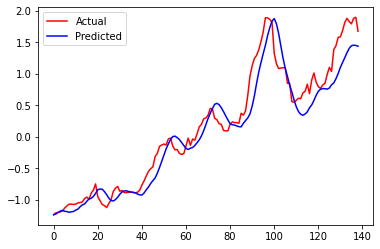

In [161]:
plt.plot(final['Actual'],label='Actual',color='red')
plt.plot(final['Predicted'],label='Predicted',color='blue')
plt.legend()

##Prediction using Time Stamp approach

In [38]:
ytest=model.predict(X_train_shape_pred)

In [39]:
y_final_pred=sc2.inverse_transform(ytest)
y_final_pred

array([[174.95248],
       [175.0057 ],
       [175.11812],
       [175.29245],
       [175.41554],
       [175.5315 ],
       [175.689  ],
       [175.74538],
       [176.02771],
       [176.53653],
       [177.09892],
       [177.29158],
       [177.91942],
       [178.49173],
       [179.22403],
       [178.85088],
       [178.80342],
       [178.86827],
       [178.47394],
       [177.95772],
       [177.64989],
       [177.79414],
       [177.8468 ],
       [178.32455],
       [178.66649],
       [179.20557],
       [179.54057],
       [180.02966],
       [180.03424],
       [180.23804],
       [180.52211],
       [180.43489],
       [180.56839],
       [180.79715],
       [180.97137],
       [181.0671 ],
       [181.57887],
       [181.86037],
       [181.95053],
       [182.2034 ],
       [182.30557],
       [182.31226],
       [182.3184 ],
       [181.98172],
       [182.01682],
       [182.15114],
       [182.28749],
       [182.23875],
       [182.49359],
       [182.5588 ],


Predicting Values

In [40]:
final_dollar_pred=pd.DataFrame(y_final_pred)
final_dollar_pred.columns=['Predicted Value']
final_dollar_pred

,Predicted Value
0,174.952484
1,175.005707
2,175.118118
3,175.292450
4,175.415543
...,...
150,228.747986
151,230.747559
152,232.273697
153,234.167374


In [41]:
df_test

,Dollar Price,Crude Price,XAU Price
Date,,,
2022-02-17,175.20,91.76,332522.0
2022-02-18,175.60,91.07,333266.0
2022-02-21,175.60,92.65,334698.0
2022-02-22,176.00,92.35,334029.0
2022-02-23,176.00,92.10,335895.0
...,...,...,...
2022-09-20,238.50,84.45,396984.0
2022-09-21,237.80,82.94,397932.0
2022-09-22,239.50,83.49,399199.0


In [42]:
#del(fully_final)

In [43]:
pred=list(final_dollar_pred.iloc[:,0])

In [44]:
fully_final=df_test


In [45]:
fully_final.insert(1,'Predicted Dollar',pred,True)

In [46]:
fully_final[30:50]

,Dollar Price,Predicted Dollar,Crude Price,XAU Price
Date,,,,
2022-03-31,183.40,180.522110,100.28,355079.0
2022-04-01,183.90,180.434891,99.27,353891.0
2022-04-04,183.20,180.568390,103.28,353990.0
2022-04-05,185.10,180.797150,101.96,355927.0
2022-04-06,186.05,180.971375,96.23,358148.0
2022-04-07,188.00,181.067093,96.03,363079.0
2022-04-08,184.00,181.578873,98.26,358217.0
2022-04-11,182.82,181.860367,94.29,357002.0
2022-04-12,181.62,181.950531,100.60,357081.0


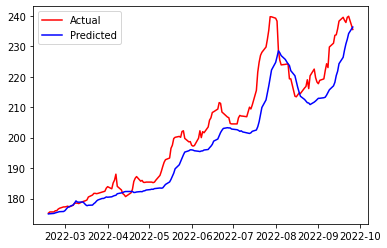

In [47]:
plt.plot(fully_final['Dollar Price'],label='Actual',color='red')
plt.plot(fully_final['Predicted Dollar'],label='Predicted',color='blue')
plt.legend()